<a href="https://colab.research.google.com/github/NavneetSajwan/Parking-space-allocation/blob/master/Parking_Space_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 47.2MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 276kB 4.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=864b68272320a9c0841dbeb2744e6d04826875080988f129197190ecc33b944c
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 6616 (delta 12), reused 26 (delta 12), pack-reused 6572
Receiving objects: 100% (6616/6616), 3.19 MiB | 7.50 MiB/s, done.
Resolving deltas: 100% (4657/4657), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.2MB 5.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=1cbb4b3d16377f3b1b28a863e69bc3072cef6accb9ca12232b5ee87053929b79
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
  Created wheel for pycocotools: filename=pycocotools-2.0.1-cp36-cp36m-linux_x86_64.whl size=266504 sha256=8f0eb415e9162d001670d8ab33e4a87c87c99c08f0394117a58b487a089be9a2
  Stored in directory: /root/.cache/pip/wheels/86/19/08/49b25f258ead1f861c9ab2fc41f73636f2928859adbb0e9797
Success

### Restart notebook before going ahead


In [1]:
import torch
from detectron2.structures import Instances
from detectron2.utils.visualizer import ColorMode

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import json 
import codecs

from torch import tensor
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

### Load Model

In [2]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.4
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

Loading config /content/detectron2_repo/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
model_final_971ab9.pkl: 228MB [00:03, 61.0MB/s]                           


In [75]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.4
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

### Helper Functions

In [3]:
def custom_output(outputs, indices, im):
  idx  = indices
  image_height = im.shape[0]
  image_width = im.shape[1]
  # idx = (outputs["instances"].scores>thresh).nonzero().flatten()
  op_dict = {'pred_boxes':outputs["instances"].pred_boxes[idx],
           'scores':outputs["instances"].scores[idx],
           'pred_classes':outputs["instances"].pred_classes[idx]}
  op = Instances((image_height, image_width), **op_dict)
  final_op = {'instances': op}
  return final_op

In [4]:
def car_counter(image, text):
  font = cv2.FONT_HERSHEY_SIMPLEX 
  
  # Position of the text on image, It's the bottom left corner
  org = (20, 30) 
  
  # fontScale 
  fontScale = 0.75
    
  # Blue color in BGR 
  color = (255,0, 0) 
    
  # Line thickness of 2 px 
  thickness = 2

  # Using cv2.putText() method 
  image = cv2.putText(image, text , org, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 
  return image

In [5]:
def bb_intersection_over_union(boxA, boxB):
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = torch.max(boxA[0], boxB[:,0])
  yA = torch.max(boxA[1], boxB[:,1])
  xB = torch.min(boxA[2], boxB[:,2])
  yB = torch.min(boxA[3], boxB[:,3])
  # print(xA.shape, yA.shape, xB.shape, yB.shape)
  # compute the area of intersection rectangle
  z = torch.tensor(0)
  interArea = torch.max(z, xB - xA + 1) * torch.max(z, yB - yA + 1)
  # print("interarea",interArea.shape)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[:,2] - boxB[:,0] + 1) * (boxB[:,3] - boxB[:,1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  num, denum = interArea, (boxAArea + boxBArea - interArea)
  # print("iou = {} / {}".format(num, denum))
  # print("iou = ", num/denum.type(torch.FloatTensor))
  # print("iou = ", num/denum)
  iou = interArea / (boxAArea + boxBArea - interArea).type(torch.FloatTensor)
  # return the intersection over union value
  return iou

In [11]:
def draw_output(torchint_preds, torch_bbox, img, iou_thresh = 0.3):
  oc, vc = 0, 0
  for label in torch_bbox:
    # iou_list = []
    # for pred in torchint_preds:
    # print('preds', torchint_preds.shape)
    iou = bb_intersection_over_union(label, torchint_preds)
    # iou_list.append(iou)
      # img = cv2.rectangle(img,(pred[0], pred[1]), (pred[2], pred[3]), (255,0,0), 2)
    # print(iou)
    iou_max = torch.max(iou)
    if iou_max > 0.3:
      color = (0,255,0)
      oc = oc + 1
    else:
      color = (0,0,255)
      vc = vc + 1
    img = cv2.rectangle(img,(label[0], label[1]), (label[2], label[3]), color, 2)
  return img, oc, vc

In [15]:
#for 1st parking space
def generate_label_bboxes():
  label_path = '/content/label.json'
  data = json.load(codecs.open(label_path, 'r', 'utf-8-sig')) 
  parking_spaces = data['parking']['space']
  bbox_arr = []
  bbox = []
  for parking_space in parking_spaces:
    coordinates = parking_space['contour']['point']
    npts = []
    xs = []
    ys = []
    for item in coordinates:
      x, y = int(item['_x']), int(item['_y'])
      xs.append(x)
      ys.append(y)

    xmin, ymin, xmax, ymax = min(xs), min(ys), max(xs), max(ys)
    bbox.append([xmin, ymin, xmax, ymax])
  bbox_arr = np.asarray(bbox)
  torch_bbox = tensor(bbox_arr)
  return torch_bbox

In [7]:
# for 2nd parking space
def label_bbox_generator():
  f = open('/content/via_project_26Aug2020_11h59m_json.json')
  data = json.load(f)
  space_list = data['output.jpg1428438']['regions']
  bbox_list = []
  for space in space_list:
    bbox = space['shape_attributes']
    h,w,x,y = bbox['height'], bbox['width'], bbox['x'], bbox['y'] 
    x1,y1,x2,y2 = map(int,(x/3, y/3, (x + w)/3, (y + h)/3))
    bbox_list.append([x1, y1, x2, y2])
  bbox_arr = np.asarray(bbox_list)
  torch_bbox = tensor(bbox_arr)
  return torch_bbox

In [71]:
def gen_bbox_predictions(im):
  outputs = predictor(im)
  op = outputs
  a = outputs["instances"].pred_classes

  car = (a==2).nonzero().flatten()
  truck = (a==7).nonzero().flatten()
  person = (a==0).nonzero().flatten()
  bus = (a==5).nonzero().flatten()
  indices = torch.cat((car, truck, bus))

  op = custom_output(outputs, indices, im)
  # preds = outputs['instances'].pred_boxes
  preds = op['instances'].pred_boxes
  torch_preds = preds.tensor
  torchint_preds = torch_preds.type(torch.LongTensor)
  # print('tip type', type(torchint_preds))
  return torchint_preds, op, car, truck, bus, person

In [ ]:
def label_bbox_generator_via():
  f = open('/content/via_project_27Aug2020_9h20m_json.json')
  data = json.load(f)
  space_list = data['output.jpg1428438']['regions']
  bbox_list = []
  for space in space_list:
    bbox = space['shape_attributes']
    h,w,x,y = bbox['height'], bbox['width'], bbox['x'], bbox['y'] 
    x1,y1,x2,y2 = map(int,(x/3, y/3, (x + w)/3, (y + h)/3))
    bbox_list.append([x1, y1, x2, y2])
  bbox_arr = np.asarray(bbox_list)
  torch_bbox = tensor(bbox_arr)
  return torch_bbox

In [12]:
def draw_stats(image, text,  org):
  font = cv2.FONT_HERSHEY_SIMPLEX 
  
  # Position of the text on image, It's the bottom left corner
  # org = (700, 30) 
  
  # fontScale 
  fontScale = 0.75
    
  # Blue color in BGR 
  color = (0,0, 255) 
    
  # Line thickness of 2 px 
  thickness = 2
  # Using cv2.putText() method 
  image = cv2.putText(image, text , org, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 
  return image

In [13]:
def drawall_stats(img_out, oc, vc, car, truck, bus, person):
  # text = "Car: "+str(len(car))
  # img_out = draw_stats(img_out, text, (50, 700))

  # text = "Truck: "+str(len(truck))
  # img_out = draw_stats(img_out, text, (50, 670))

  # text = "Bus: "+str(len(bus))
  # img_out = draw_stats(img_out, text, (50, 640))

  # text = "Person: "+str(len(person)-1)
  # img_out = draw_stats(img_out, text, (50, 610))

  text = "Occupied: "+str(oc)
  img_out = draw_stats(img_out, text, (1000, 700))

  text = "Vacant: "+str(vc)
  img_out = draw_stats(img_out, text, (1000, 670))

  text = "Total Parking: "+str(vc+oc)
  img_out = draw_stats(img_out, text, (1000, 640))
  return img_out

# Inference on Image

In [17]:
from time import time

In [18]:
import pdb

In [62]:
imgdir_path = '/content/content/PKimages'

In [63]:
import os
imgname_list = os.listdir(imgdir_path)

In [ ]:
imgname_list

In [30]:
from collections import defaultdict

In [52]:
str(key)

'tensor([1126,   83, 1165,  129])'

In [100]:
torch.argmax(torch.tensor([12,4,5,70,8]))

tensor(3)

In [152]:
parking = torch.tensor((1,4))
parking

tensor([1, 4])

In [167]:
parking = torch.tensor([1])
if len(parking):
  print('shit')

shit


In [190]:
parking = torch.tensor([[-1,-1,-1,-1]])
parking

tensor([[-1, -1, -1, -1]])

In [191]:
len(parking)

1

In [ ]:
parking = torch.tensor([[-1,-1,-1,-1]])
f = torch.tensor([[-1]])
for imgname in imgname_list[:2]:
  # imgname = '2013-03-11_10_25_05.jpg'
  img_path = os.path.join(imgdir_path, imgname)
  im = cv2.imread(img_path)
  torch_bbox = generate_label_bboxes()
  torchint_preds, op, car, truck, bus, person=gen_bbox_predictions(im)#boxes for car, bus, truck
  # print(len(torchint_preds))
  for box in torchint_preds:
    if len(parking)>1:
      # print(parking)
      iou = bb_intersection_over_union(box, parking)
      iou_max, idx = torch.max(iou), torch.argmax(iou)
      if iou_max > 0.6:
        print("Re entering")
        f[idx] =  f[idx] + 1
      else:
        parking = torch.cat((parking, box.view(1,-1)))
        f = torch.cat((f,torch.tensor([[1]])))
    else:
      parking = torch.cat((parking, box.view(1,-1)))
      f = torch.cat((f,torch.tensor([[1]])))      


In [206]:
parking.shape, f.shape

(torch.Size([57, 4]), torch.Size([57, 1]))

In [197]:
box.shape, parking.shape

(torch.Size([4]), torch.Size([1, 4]))

In [193]:
parking

tensor([[-1, -1, -1, -1]])

In [ ]:
%debug

tensor([-1, -1, -1, -1])

In [200]:
b = torch.tensor([2,3])
c = b.view(1,-1)
c

tensor([[2, 3]])

In [199]:
a = torch.tensor([1,2])
a = torch.stack((a,torch.tensor([1,4])))
a

tensor([[1, 2],
        [1, 4]])

In [179]:
a.shape, torch.tensor([1,4]).shape

(torch.Size([4]), torch.Size([2]))

In [148]:
a[0,:]

tensor([2, 3])

In [141]:
a = torch.tensor([2,5,4,67])
torch.cat((a, torch.tensor([9])))

tensor([ 2,  5,  4, 67,  9])

In [97]:
parking = torch.stack(list(box_dict.keys())) # coool
parking.shape

torch.Size([79, 4])

In [61]:
!unzip -q '/content/drive/My Drive/Projects/Parking allocation/PKimages.zip'

In [ ]:
#person = 0
#car = 2
#truck = 7
#bus = 5
img_path = '/content/images/img2.jpg'
im = cv2.imread(img_path)
torch_bbox = generate_label_bboxes()
# torch_bbox = label_bbox_generator_via()
torchint_preds, car, truck, bus, person=gen_bbox_predictions(im)#boxes for car, bus, truck
tic = time()
img_out, oc, vc = draw_output(torchint_preds, torch_bbox, im, 0.4)
toc = time()
print("time duration:", toc-tic)
img_out = drawall_stats(img_out, oc, vc, car, truck, bus, person)
# print(type(img_out))
cv2_imshow(img_out)

for item in torchint_preds:
  print(item)

In [ ]:
box_dict = {}
for imgname in imgname_list[:2]:
  img_path = os.path.join(imgdir_path, imgname)
  im = cv2.imread(img_path)
  torch_bbox = generate_label_bboxes()
  torchint_preds, op, car, truck, bus, person=gen_bbox_predictions(im)#boxes for car, bus, truck
  # for key in torchint_preds:
  #   if key in box_dict:
  #     print("Re entering")
  #     box_dict[str(key)] =  box_dict[str(key)] + 1
  #   else:
  #     box_dict[str(key)] = 1
  v = Visualizer(im[:, :, ::-1],
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1.0,
               instance_mode = ColorMode.SEGMENTATION
               )
  v = v.draw_instance_predictions(op["instances"].to("cpu"))
  # v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img = v.get_image()[:, :, ::-1]
  # text = "No. of cars: "+str(len(indices))
  # img = car_counter(img, text)
  cv2_imshow(img)
  # img_out, oc, vc = draw_output(torchint_preds, torch_bbox, im, 0.4)
  # img_out = drawall_stats(img_out, oc, vc, car, truck, bus, person)
  # cv2_imshow(img_out)

In [ ]:
def parking_spot_locator():

  

In [20]:
key = torch.tensor([1,2,3,4])

In [21]:
dcik = {}

In [22]:
dcik[key]= 10

In [24]:
dcik

{tensor([1, 2, 3, 4]): 10}

In [ ]:
%debug

In [ ]:
from time import time

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
tiic = time()
cap = cv2.VideoCapture("/content/drive/My Drive/Projects/Parking allocation/sample_lr.mp4")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
print(frame_width, frame_height)
out = cv2.VideoWriter('out.mp4',fourcc, 20.0, (frame_width, frame_height))
count = 0
torch_bbox = label_bbox_generator_via()
while(cap.isOpened()):
  tic = time()
  ret, frame = cap.read()
  toc = time()
  print("frame read time:", toc-tic)
  count = count+1
  if count % 3 == 0:
    if ret==True:
      tic = time()
      torchint_preds, car, truck, bus, person=gen_bbox_predictions(frame)
      toc = time()
      print("prediction time:", toc-tic)
      
      tic = time()
      img_out, oc, vc = draw_output(torchint_preds, torch_bbox, frame, 0.3)
      toc = time()
      print("draw output time:", toc-tic)

      tic = time()
      img_out = drawall_stats(img_out, oc, vc, car, truck, bus, person)
      toc = time()
      print("draw all stats time:", toc-tic)

      tic = time()
      out.write(img_out)
      toc = time()
      print("out.write time:", toc-tic)
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()
tooc = time()
print("total time", tooc-tiic)

tip type <class 'torch.Tensor'>


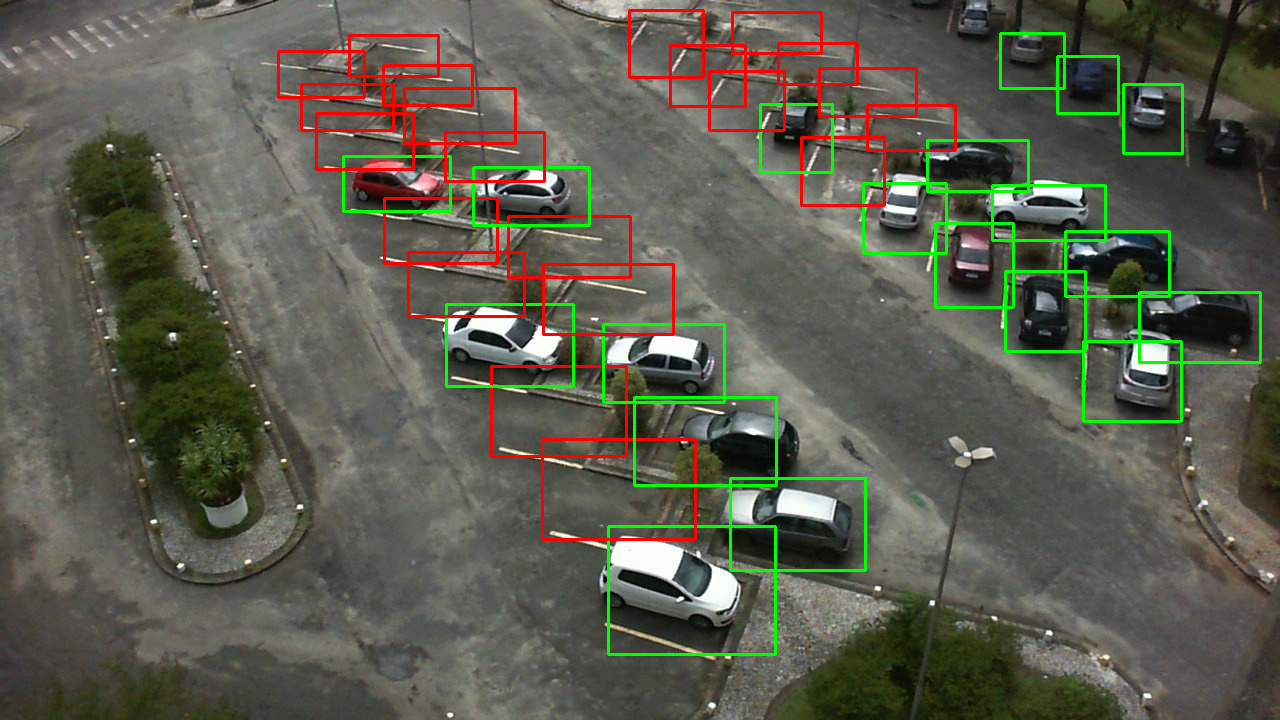

In [ ]:
# img = cv2.imread(img_path)
torchint_preds=gen_bbox_predictions(img_path)
for label in torch_bbox:
  iou_list = []
  for pred in torchint_preds:
    iou = bb_intersection_over_union(label, pred)
    iou_list.append(iou)
    iou_max = max(iou_list)
    if iou_max > 0.3:
      color = (0,255,0)
    else:
      color = (0,0,255)
    # img = cv2.rectangle(img,(pred[0], pred[1]), (pred[2], pred[3]), (255,0,0), 2)
  img = cv2.rectangle(img,(label[0], label[1]), (label[2], label[3]), color, 2)
cv2_imshow(img)

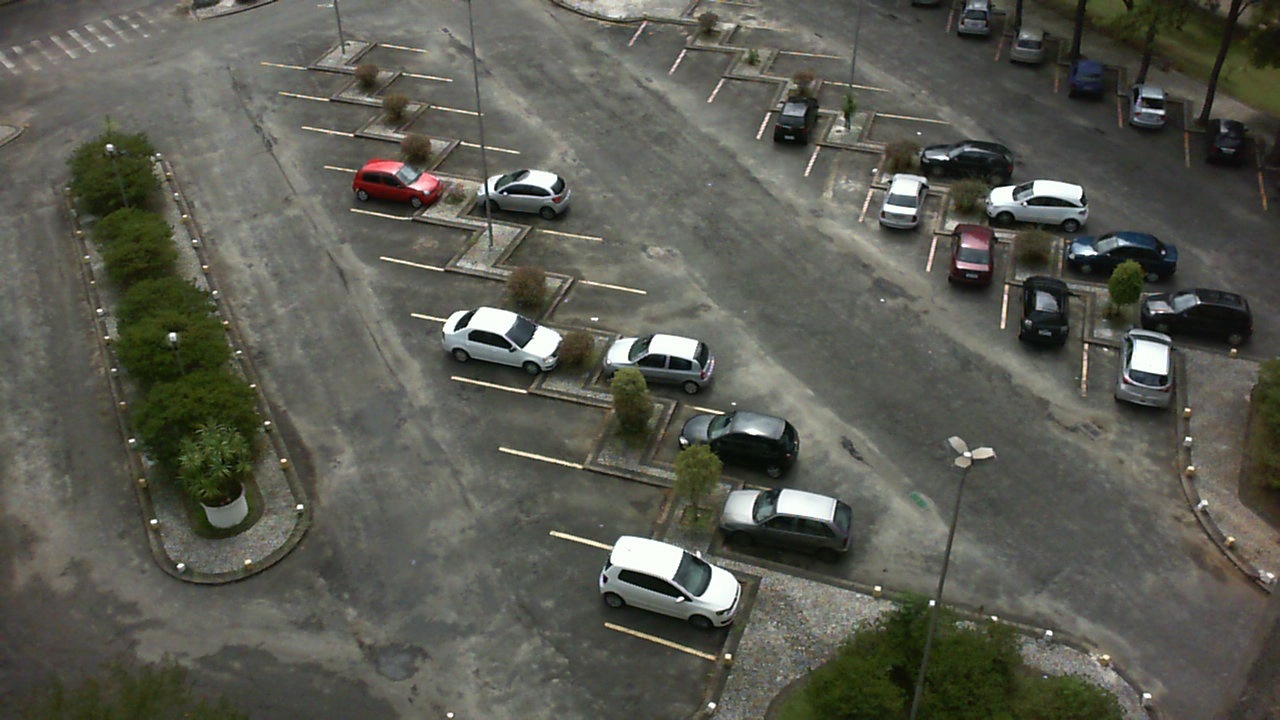

In [ ]:
cv2_imshow(im)

In [ ]:
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
a = outputs["instances"].pred_classes
indices = (a==2).nonzero().flatten()
op = custom_output(outputs, indices, im)

In [ ]:
preds = op['instances'].pred_boxes
torch_preds = preds.tensor
torchint_preds = torch_preds.type(torch.IntTensor)

In [ ]:
v = Visualizer(im[:, :, ::-1],
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1.2,
              #  instance_mode = ColorMode.SEGMENTATION
               )
v = v.draw_instance_predictions(op["instances"].to("cpu"))
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:, :, ::-1]
text = "No. of cars: "+str(len(indices))
img = car_counter(img, text)
cv2_imshow(img.get())

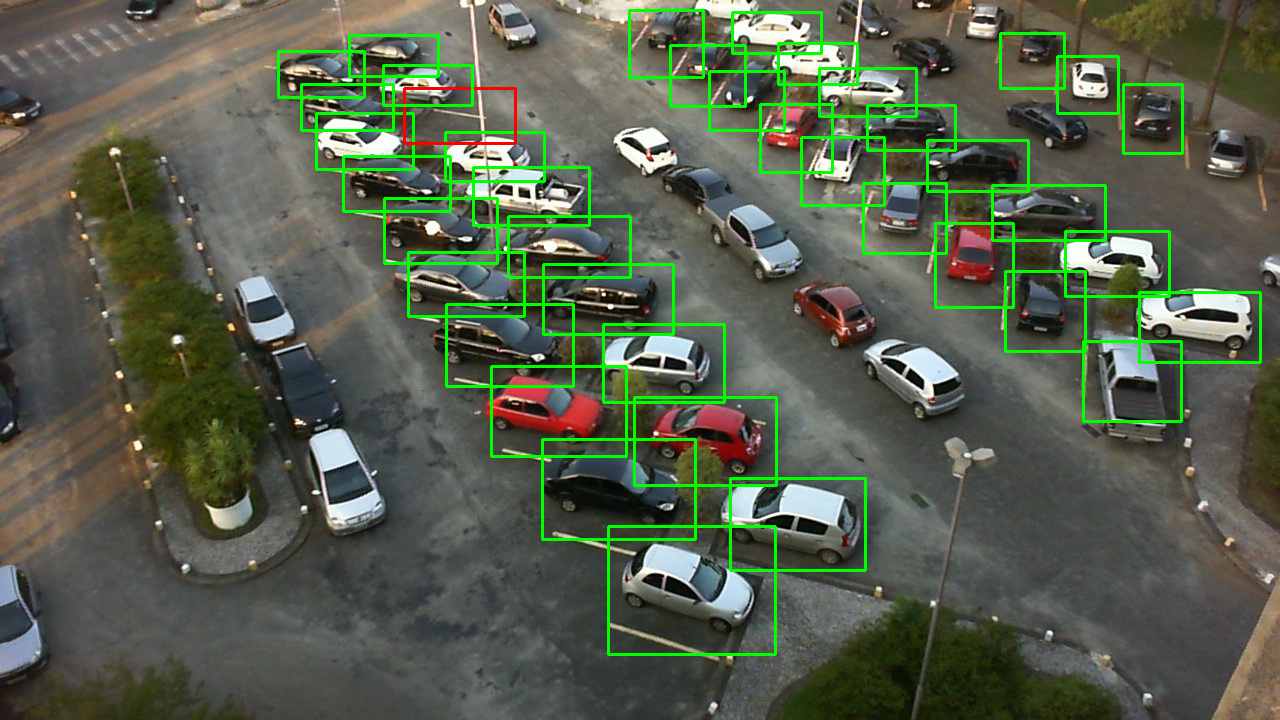

In [ ]:
cv2_imshow(img)

In [ ]:
v = Visualizer(im[:, :, ::-1],
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1.2,
               instance_mode = ColorMode.SEGMENTATION
               )
v = v.draw_instance_predictions(op["instances"].to("cpu"))
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:, :, ::-1]
text = "No. of cars: "+str(len(indices))
img = car_counter(img, text)
cv2_imshow(img.get())
# cv2_imshow(img)

# Inference on video

In [ ]:
vid_path = "/content/video-clip (1).mp4"

In [ ]:
def video_inference(im):
  outputs = predictor(im)
  a = outputs["instances"].pred_classes
  indices = (a==2).nonzero().flatten()
  op = custom_output(outputs, indices, im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0, instance_mode=ColorMode.SEGMENTATION)
  v = v.draw_instance_predictions(op["instances"].to("cpu"))
  img = v.get_image()[:, :, ::-1]
  text = "No. of cars: "+str(len(indices))
  img = car_counter(img, text)
  return img.get()

### AVI output

In [ ]:
from time import time

cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.4
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
cap = cv2.VideoCapture(vid_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# Define the codec and create VideoWriter object
print("frame_width,frame height:", frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_x.mp4',fourcc, 20.0, (frame_width, frame_height))
print(type(out), out)
count = 0
tic = time()
while(cap.isOpened()):
    count = count + 1
    ret, frame = cap.read()
    if ret==True:
      if count%4 == 0:
        img_out = video_inference(frame)
        # cv2_imshow(img_out)
        # break
        out.write(img_out)
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    else:
        break
toc = time()
print("Elapsed time:", toc -tic)
# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

frame_width,frame height: 1280 720
<class 'cv2.VideoWriter'> <VideoWriter 0x7f4b08a78b90>
Elapsed time: 15.280763626098633


### MP4 output

In [ ]:
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.4
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
cap = cv2.VideoCapture(vid_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# Define the codec and create VideoWriter object
print("frame_width,frame height:", frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'H264')
out = cv2.VideoWriter('output_x.mp4',fourcc, 20.0, (frame_width, frame_height))
print(type(out), out)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
      img_out = video_inference(frame)
      # cv2_imshow(img_out)
      # break
      out.write(img_out)
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

frame_width,frame height: 1280 720
<class 'cv2.VideoWriter'> <VideoWriter 0x7f4aee427c30>


In [ ]:
from time import time

cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.4
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
cap = cv2.VideoCapture(vid_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# Define the codec and create VideoWriter object
print("frame_width,frame height:", frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_x.avi',fourcc, 20.0, (frame_width, frame_height))
print(type(out), out)
count = 0
tic = time()
while(cap.isOpened()):
    count = count + 1
    if count%3 == 0:
      print(count)
      ret, frame = cap.read()
      if ret==True:
        img_out = video_inference(frame)
        # cv2_imshow(img_out)
        # break
        out.write(img_out)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
      else:
          break
toc = time()
print("Elapsed time:", toc -tic)
# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

### Real-time model

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data, a, b = eval_js('takePhoto({})'.format(quality))
  print("width, height:", a, b)
  binary = b64decode(data.split(',')[1])
  print("\nbinary data:", binary, type(binary))
  with open(filename, 'wb') as f:
    f.write(binary)
  # return filename
  return binary

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

'int' object is not iterable


In [ ]:
filename

'photo.jpg'

In [ ]:
import numpy as np

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
image = np.frombuffer(filename, np.uint8)
img = cv2.imdecode(image, flags=cv2.IMREAD_COLOR)
img.shape